<a href="https://colab.research.google.com/github/rdwn354/E-Blink/blob/master/colab/re_create_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# dataset
path_dataset = "/content/gdrive/MyDrive/datasets/Dataset"

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Function to load images and labels from the dataset
def load_data_from_folders(path_dataset):
    images = []
    labels = []
    for label, folder in enumerate(["open", "close"]):
        folder_path = os.path.join(path_dataset, folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            # Read the image and resize it to a fixed size (e.g., 224x224)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (224, 224))  # Adjust the size to 224x224 pixels
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
# Load images and labels from the dataset
X, y = load_data_from_folders(path_dataset)

In [ ]:


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize pixel values to range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Define the dimensions and channels of your input images
img_height, img_width, channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)


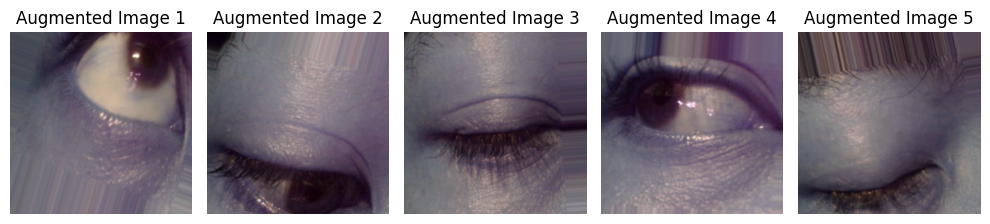

In [ ]:
import matplotlib.pyplot as plt

# Generate augmented images
augmented_images = []
num_augmented_images = 5  # Number of augmented images to generate
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=1):
    augmented_image = cv2.cvtColor(X_batch[0], cv2.COLOR_BGR2RGB)
    augmented_images.append(X_batch[0])
    if len(augmented_images) >= num_augmented_images:
        break

# Display augmented images
plt.figure(figsize=(10, 5))
for i, image in enumerate(augmented_images):
    plt.subplot(1, len(augmented_images), i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Augmented Image {i + 1}')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, channels)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Add dropout with rate 0.5
    layers.Dense(1, activation='sigmoid')
])

# Print model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model using data augmentation
train_generator = datagen.flow(X_train, y_train, batch_size=32)
history = model.fit(train_generator, steps_per_epoch=len(X_train)//32, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
30/30 [==============================] - 23s 435ms/step - loss: 0.6220 - accuracy: 0.7027 - val_loss: 0.3835 - val_accuracy: 0.8306
Epoch 2/10
30/30 [==============================] - 10s 329ms/step - loss: 0.3900 - accuracy: 0.8342 - val_loss: 0.2473 - val_accuracy: 0.9298
Epoch 3/10
30/30 [==============================] - 13s 417ms/step - loss: 0.2572 - accuracy: 0.9091 - val_loss: 0.1972 - val_accuracy: 0.9298
Epoch 4/10
30/30 [==============================] - 11s 383ms/step - loss: 0.2323 - accuracy: 0.9091 - val_loss: 0.2572 - val_accuracy: 0.9008
Epoch 5/10
30/30 [==============================] - 10s 333ms/step - loss: 0.1470 - accuracy: 0.9529 - val_loss: 0.0759 - val_accuracy: 0.9752
Epoch 6/10
30/30 [==============================] - 11s 357ms/step - loss: 0.2018 - accuracy: 0.9337 - val_loss: 0.0518 - val_accuracy: 0.9917
Epoch 7/10
30/30 [==============================] - 12s 387ms/step - loss: 0.2325 - accuracy: 0.9326 - val_loss: 0.0147 - val_accuracy: 1.0000

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Accuracy: {test_accuracy}')

8/8 [==============================] - 0s 18ms/step - loss: 0.0089 - accuracy: 1.0000
Test Accuracy: 1.0


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


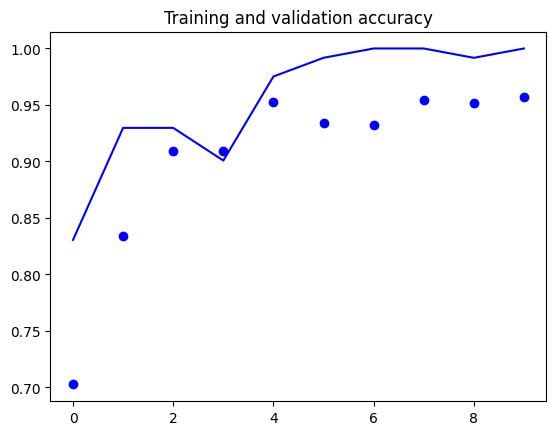

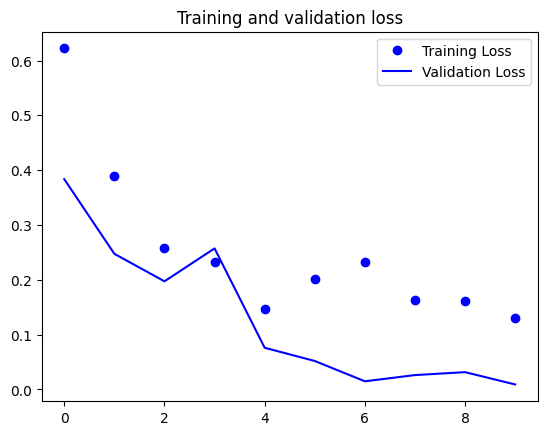

In [ ]:
# Plot training results
plot_loss_acc(history)

8/8 [==============================] - 0s 16ms/step


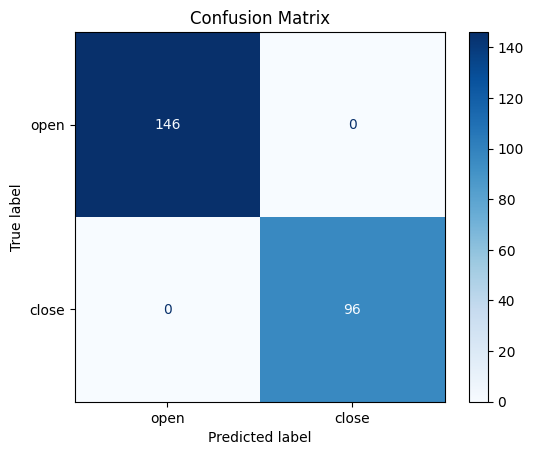

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert labels back to original format for confusion matrix calculation
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
y_test_binary = y_test

# Calculate confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["open", "close"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save the model
model.save('/content/gdrive/MyDrive/datasets/model/model_EBlink.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Upload user's photo
uploaded = files.upload()

# Load the trained model
model = load_model("/content/gdrive/MyDrive/datasets/model/model_EBlink.h5")

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Get the uploaded image path
image_path = next(iter(uploaded))

# Preprocess the image
input_image = preprocess_image(image_path)

# Perform prediction
prediction = model.predict(input_image)

# Convert prediction to class label
class_label = "open" if prediction < 0.5 else "close"

# Display prediction result
print("Prediction:", class_label)


In [ ]:
import os
import cv2
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

# Load the pre-trained model
model = load_model('/content/gdrive/MyDrive/datasets/model/model_EBlink.h5')  # Provide the path to your trained model file

# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict classes for images
def predict_images_in_folder(folder_path):
    predictions = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Assuming photos are in these formats
            img_path = os.path.join(folder_path, filename)
            img = load_and_preprocess_image(img_path)
            prediction = model.predict(img)
            predicted_class = np.argmax(prediction)
            class_label = "open" if prediction < 0.5 else "close"  # Assigning class labels based on a threshold
            predictions.append((filename, predicted_class, class_label))
    return predictions

# Provide the path to the folder containing photos
folder_path = "/content/gdrive/MyDrive/datasets/dataset_modified/iman"  # Update with your folder path
predictions = predict_images_in_folder(folder_path)

# Display predictions
for filename, predicted_class, class_label in predictions:
    print(f"Image: {filename}, Predicted Class: {predicted_class}, Class Label: {class_label}")


1/1 [==============================] - 0s 24ms/step
Image: dataset_iman_26.jpg, Predicted Class: 0, Class Label: open
Image: dataset_iman_22.jpg, Predicted Class: 0, Class Label: open
Image: dataset_iman_21.jpg, Predicted Class: 0, Class Label: open
Image: dataset_iman_2.jpg, Predicted Class: 0, Class Label: close
Image: dataset_iman_20.jpg, Predicted Class: 0, Class Label: open
Image: dataset_iman_17.jpg, Predicted Class: 0, Class Label: close
Image: dataset_iman_19.jpg, Predicted Class: 0, Class Label: close
Image: dataset_iman_18.jpg, Predicted Class: 0, Class Label: close
Image: dataset_iman_14.jpg, Predicted Class: 0, Class Label: open
Image: dataset_iman_15.jpg, Predicted Class: 0, Class Label: open
Image: dataset_iman_0.jpg, Predicted Class: 0, Class Label: close
Image: dataset_iman_13.jpg, Predicted Class: 0, Class Label: open
Image: dataset_iman_16.jpg, Predicted Class: 0, Class Label: close
Image: dataset_iman_12.jpg, Predicted Class: 0, Class Label: open
Image: dataset_iman_